## Parsing the CSSE Daily Data for COVID 19:
https://github.com/CSSEGISandData/COVID-19

Using the code provided by Prof. James Sharpnack
https://github.com/jsharpna/CovidResponse208

The population dataset is from the 2019 census




# PREDICTION TASK 1 (Using the Daily Data)

Here we simply regress the input data on the Incident_Rate label using the daily data. The features are Province_State, Population, Elapsed_Days and Percentage_Home

In [53]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as CrossValidate
from matplotlib.pyplot import rcParams


plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from patsy import dmatrices
import statsmodels.api as sm


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')


TensorFlow version: 2.1.0
Eager execution: True


In [54]:
#standardizer function which standardizes the numerical data and encodes the categorical data with LabelEncoder
def standardize_fit1 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = LabelEncoder()
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    classes= encoder.classes_

    return classes, scaler, encoder 

def standardize_transfrom1( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X).reshape(-1, 1)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [55]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [56]:
# K-fold cross validation 
def CrossValKF (model, X , K = 10):
    n,_ = X.shape
    kf = CrossValidate.KFold(shuffle=False, n_splits = K)
    absolute_errorsList = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_true= y_val, y_pred= y_pred)
        absolute_errorsList.append(error)
    return np.mean(absolute_errorsList)

In [57]:
# cross validation with Leave one out
def CrossValLOO (model, X):
    loo = CrossValidate.LeaveOneOut()
    absolute_errorsList = []
    for train_index, val_index in loo.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_true= y_val, y_pred= y_pred)
        absolute_errorsList.append(error)
    return np.mean(absolute_errorsList)

In [58]:
#importing the train set
X_tr = pd.read_csv('../data/X_daily_tr.csv')   
y_tr = pd.read_csv('../data/y_daily_tr.csv') 
print(X_tr.shape)
print(y_tr.shape)

(3573, 5)
(3573, 2)


In [59]:
# just to make sure if any Null is left
print ("number of nulls left is ", len(X_tr[X_tr.isnull().values == True].head()))

number of nulls left is  0


In [60]:
# only keeping the data where incident rate is more than 0.5
X_tr = X_tr[y_tr['Incident_Rate'] >= 0.5]
y_tr = y_tr[y_tr['Incident_Rate'] >= 0.5]

In [61]:
X_tr.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
157,2020-02-21,Nebraska,1934408.0,0,19.236149
265,2020-03-04,Washington,7614893.0,0,23.675703
282,2020-03-05,Washington,7614893.0,1,24.347069
307,2020-03-06,Washington,7614893.0,2,24.577092
337,2020-03-07,Washington,7614893.0,3,27.524526


In [62]:
# (Explore can we cross validate with splitting by each day?)
train_timestamps = X_tr['Date'].values
train_timestamps[:5]

array(['2020-02-21', '2020-03-04', '2020-03-05', '2020-03-06',
       '2020-03-07'], dtype=object)

In [63]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
print(X_tr.shape)
print(y_tr.shape)

(2920, 4)
(2920, 1)


In [64]:
X_tr.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
157,Nebraska,1934408.0,0,19.236149
265,Washington,7614893.0,0,23.675703
282,Washington,7614893.0,1,24.347069
307,Washington,7614893.0,2,24.577092
337,Washington,7614893.0,3,27.524526


In [65]:
X_tr.describe()

,Population,Elapsed_Days,Percentage_Home
count,2.920000e+03,2920.000000,2920.000000
mean,6.420689e+06,27.018493,37.653490
std,7.291724e+06,16.636420,6.623412
min,5.787590e+05,0.000000,17.885169
25%,1.787065e+06,13.000000,32.934542
50%,4.467673e+06,27.000000,37.216028
75%,7.614893e+06,41.000000,41.818998
max,3.951222e+07,66.000000,69.594465


In [66]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 157 to 3572
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Province_State   2920 non-null   object 
 1   Population       2920 non-null   float64
 2   Elapsed_Days     2920 non-null   int64  
 3   Percentage_Home  2920 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 114.1+ KB


In [67]:
# standardizing the training data

categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std = standardize_transfrom2(X_tr, scaler, encoder2)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)

print(X_tr_std.shape)

(2920, 55)


In [68]:
#find the id of california in the categories array (note that categories has only one elemnts and it is the array of categories so we should use categories[0])
calid = np.where(categories[0] == 'California')[0][0]
print("index of California is =", calid)
print(X_tr.head())
print(X_tr_std[:5, calid] == 1)

index of California is = 4
    Province_State  Population  Elapsed_Days  Percentage_Home
157       Nebraska   1934408.0             0        19.236149
265     Washington   7614893.0             0        23.675703
282     Washington   7614893.0             1        24.347069
307     Washington   7614893.0             2        24.577092
337     Washington   7614893.0             3        27.524526
[False False False False False]


Text(0.5, 1.0, ' Number of Days with more than 0.5 Incidence rate for each state in the training data set')

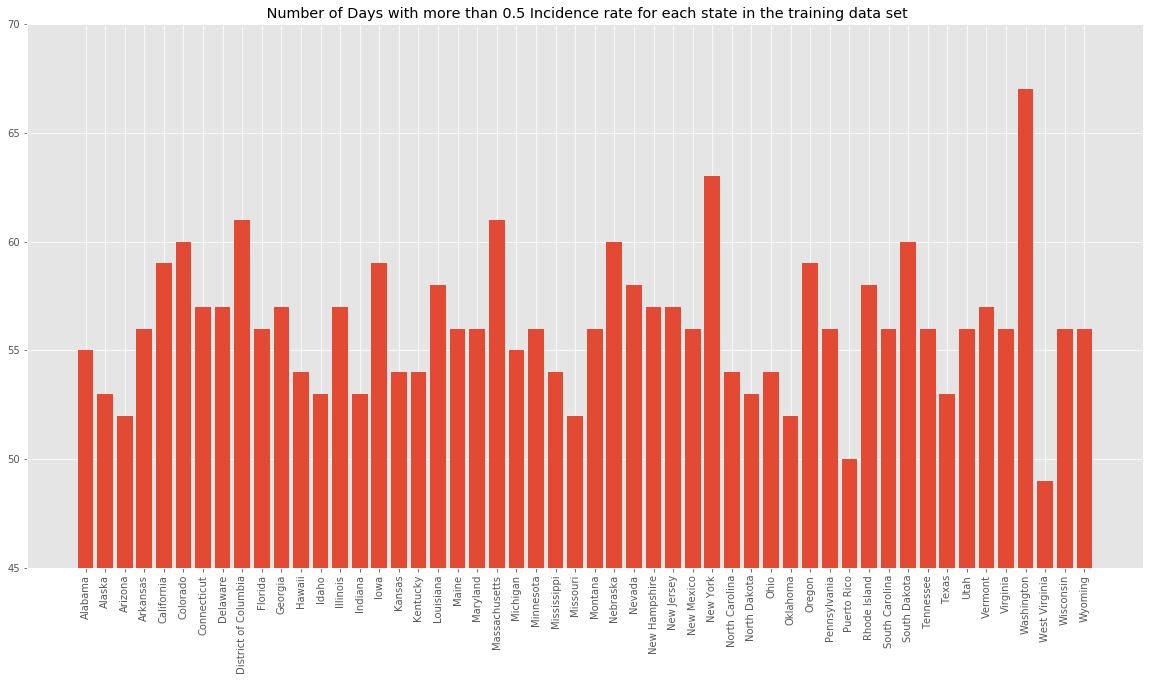

In [69]:
# calculate the total count of datas from each state
DaysWithCases = [sum(X_tr_std[:, x] == 1) for x in range(0,52)]
rcParams['figure.figsize'] = 20,10
plt.bar(categories[0], DaysWithCases)
plt.xticks(categories[0], rotation='vertical')
plt.ylim((45,70))
plt.title(" Number of Days with more than 0.5 Incidence rate for each state in the training data set")

The data is a bit unbalanced but We hope that by sing the one-hot encoding technique, we could aleviuate the balance

In [70]:
y_tr.describe()

,Incident_Rate
count,2920.000000
mean,139.077962
std,232.835254
min,0.503619
25%,16.006792
50%,60.191737
75%,145.736850
max,1712.395998


In [71]:
y_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 157 to 3572
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Incident_Rate  2920 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


In [72]:
#importing the test set
X_te = pd.read_csv('../data/X_daily_te.csv')   
y_te = pd.read_csv('../data/y_daily_te.csv') 
print(X_te.shape)
print(y_te.shape)

(780, 5)
(780, 2)


In [73]:
X_te.tail()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
775,2020-05-24,Virginia,8535519.0,70,37.320900
776,2020-05-24,Washington,7614893.0,81,39.301188
777,2020-05-24,West Virginia,1792147.0,63,30.168107
778,2020-05-24,Wisconsin,5822434.0,70,32.491617
779,2020-05-24,Wyoming,578759.0,70,34.528039


In [74]:
# only keeping the data where incident rate is more than 0.5
X_te = X_te[y_te['Incident_Rate'] >= 0.5]
y_te = y_te[y_te['Incident_Rate'] >= 0.5]


In [75]:
test_timestamps = X_te['Date'].values
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)
print(X_te.shape)
print(y_te.shape)

(780, 4)
(780, 1)


In [76]:
X_te.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
0,Alabama,4903185.0,55,26.622293
1,Alaska,731545.0,53,33.555901
2,Arizona,7278717.0,52,38.224841
3,Arkansas,3017804.0,56,26.700268
4,California,39512223.0,59,40.783996


In [77]:
#standardizing the test data from the previously fitted standardizers
X_te_std = standardize_transfrom2(X_te, scaler, encoder2)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
print(X_te_std.shape)

(780, 55)


In [78]:
y_te.describe()

,Incident_Rate
count,780.000000
mean,402.180122
std,390.947895
min,42.852678
25%,160.799613
50%,246.760960
75%,478.752059
max,1858.348711


## Designing our regression models

without any delays

1- Random Forests Regression

2- Support Vector Machine Regression 

3- Poisson Regression with Generalized linear model (from statsmodel api)

4- MLP Regression based on the Poisson Loss and Optimized with Adam Optimizer

For this Task we could use the cross validation metrics, but we have to be careful about splitting to multiple folds so as not to make the dataset unbalanced. So instead we are going to evaluate the Mean Absolute Error of the cases for the whole trainign dataset

In [79]:
# creating the dataset
X = X_tr_std
y = y_tr.values

Xt = X_te_std
yt = y_te.values

X = np.asarray(X).astype(np.float64)
y = np.asarray(y).astype(np.float64)
Xt = np.asarray(Xt).astype(np.float64)
yt = np.asarray(yt).astype(np.float64)

#number of folds in K-Fold Cross Validation
CVK = 3

# Random Forest Regressor

In [82]:
params = {
    "n_estimators": [10, 50, 100, 200, 300],
    "max_depth": [4, 8, 12, 16, 20, 32, 64]
}
best_score = np.Inf
rf = RandomForestRegressor()
for g in ParameterGrid(params):
    rf.set_params(**g)
    rf.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # score = CrossValKF(model= rf, X=X, K=CVK)
    # score = CrossValLOO(model= rf, X=X)
    #no cross validation
    y_pred = rf.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    if score < best_score:
        best_score = score
        best_grid = g

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("Params:", best_grid)

Mean Abosulte Error score of the best model: 4.04321
Params: {'max_depth': 64, 'n_estimators': 200}


Mean Abosulte Error score of the best model on the test dataset is  : 82.88295


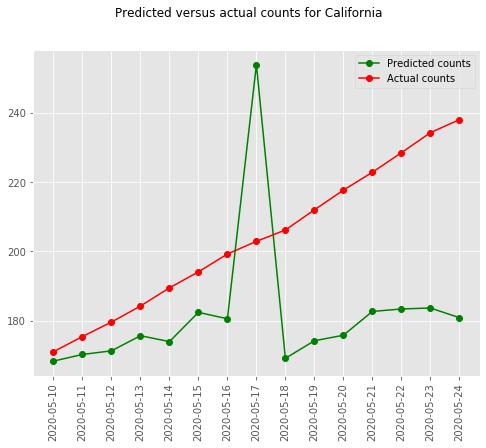

<Figure size 576x432 with 0 Axes>

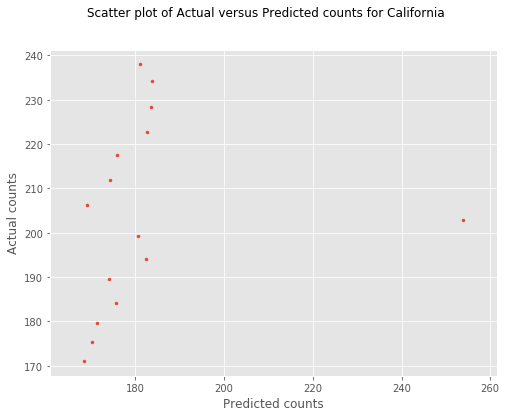

In [83]:
# on the total test dataset we find the MAE
rf.set_params(**best_grid)
rf.fit(X, y)
y_pred = rf.predict(Xt)
print("Mean Abosulte Error score of the best model on the test dataset is  : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
calidx = [X_te_std[:,calid] == 1 ]
fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

# Support Vector Machine Regressor

In [85]:
params = {
    "C" : [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
    "kernel" : ["rbf","poly","sigmoid", "linear"],
    "gamma" : ["scale"]
}

best_score = np.Inf 
svm = SVR()
for g in ParameterGrid(params):
    svm.set_params(**g)
    svm.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # score = CrossValKF(model= svm, X=X, K=CVK)
    # score = CrossValLOO(model= svm, X=X)
    #no cross validation
    y_pred = svm.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    if score < best_score:
        best_score = score
        best_grid = g

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("Params:", best_grid)

Mean Abosulte Error score of the best model: 63.05069
Params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


Mean Abosulte Error score of the best model on the test dataset is  : 236.83441


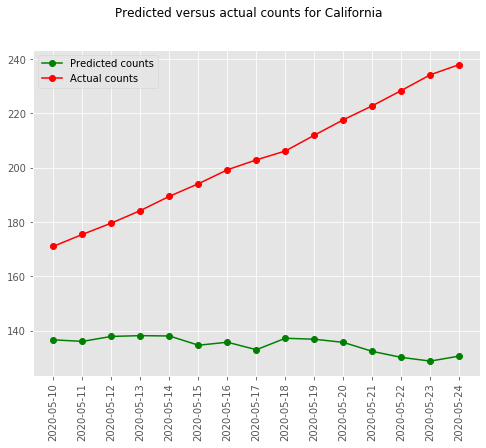

<Figure size 576x432 with 0 Axes>

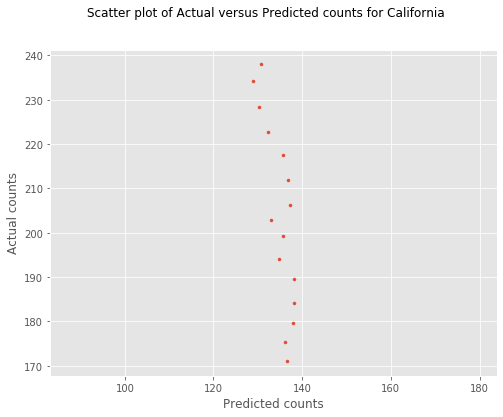

In [86]:
# on the total test dataset we find the MAE
svm.set_params(**best_grid)
svm.fit(X, y)
y_pred = svm.predict(Xt)
print("Mean Abosulte Error score of the best model on the test dataset is  : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
calidx = [X_te_std[:,calid] == 1 ]
fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

# Poisson Regression on Generalized linear Models

In [87]:
# poisson regression from TowardsDataScience at
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(Xt)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2920
Model:                            GLM   Df Residuals:                     2866
Model Family:                 Poisson   Df Model:                           53
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32801.
Date:                Sun, 07 Jun 2020   Deviance:                       49121.
Time:                        09:47:43   Pearson chi2:                 4.41e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.3613      0.016    274.551      0.000       4.330   

the Mean Absolute Error is  258.45512673619186


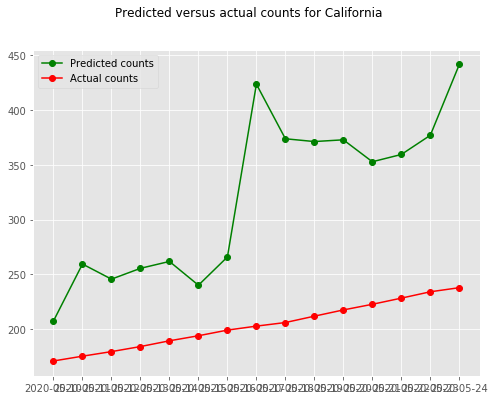

<Figure size 576x432 with 0 Axes>

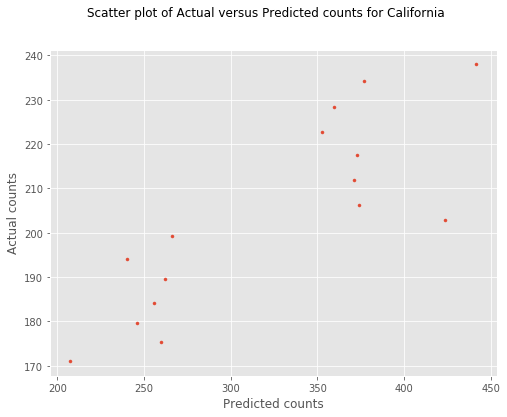

In [88]:
# on the total test dataset we find the MAE
y_pred = predictions_summary_frame['mean'].values
print("the Mean Absolute Error is ", mean_absolute_error(y_true= yt, y_pred= y_pred))

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

# Multi Layer Perceptron Regressor

We use the poisson loss in the MLP model, which is specially useful for the count data like the dataset that we have here.

In [118]:
models_fn = []

def mod0():
  model = Sequential()
  model.add(Dense(10, input_dim = 55, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod0)

def mod1():
  model = Sequential()
  model.add(Dense(20, input_dim = 55, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod1)

In [119]:
histories =[]

best_score = np.Inf 
for model_fn in models_fn:
    # build model
    print(model_fn)
    kr = KerasRegressor(build_fn= model_fn, epochs=100, batch_size= 16, verbose=0, shuffle= False)
    history = kr.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # kfold = KFold(n_splits=CVK)
    # score = cross_val_score(kr, X_tr, y_tr, cv=kfold, scoring='mae')
    # score = CrossValKF(model= kr, X=X, K=CVK)
    # score = CrossValLOO(model= kr, X=X)
    #no cross validation
    y_pred = kr.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    histories.append(history)
    if score < best_score:
        best_score = score
        best_model = model_fn
        best_history = history
        best_estimator = kr


print("Mean Abosulte Error score of the best model: %0.5f" % best_score )


<function mod0 at 0x00000226592AFA68>
Train on 2920 samples
Epoch 1/100
2920/2920 - 1s - loss: -1.6625e+01 - mae: 137.7984
Epoch 2/100
2920/2920 - 1s - loss: -2.2590e+02 - mae: 135.1568
Epoch 3/100
2920/2920 - 1s - loss: -3.1880e+02 - mae: 131.8176
Epoch 4/100
2920/2920 - 1s - loss: -3.8532e+02 - mae: 127.3617
Epoch 5/100
2920/2920 - 1s - loss: -4.3459e+02 - mae: 122.0081
Epoch 6/100
2920/2920 - 1s - loss: -4.7325e+02 - mae: 115.9815
Epoch 7/100
2920/2920 - 1s - loss: -5.0416e+02 - mae: 109.7686
Epoch 8/100
2920/2920 - 1s - loss: -5.2871e+02 - mae: 103.8112
Epoch 9/100
2920/2920 - 1s - loss: -5.4824e+02 - mae: 98.3764
Epoch 10/100
2920/2920 - 1s - loss: -5.6383e+02 - mae: 93.7183
Epoch 11/100
2920/2920 - 1s - loss: -5.7629e+02 - mae: 89.9577
Epoch 12/100
2920/2920 - 1s - loss: -5.8623e+02 - mae: 87.0163
Epoch 13/100
2920/2920 - 1s - loss: -5.9417e+02 - mae: 84.9211
Epoch 14/100
2920/2920 - 1s - loss: -6.0045e+02 - mae: 83.6285
Epoch 15/100
2920/2920 - 1s - loss: -6.0546e+02 - mae: 82.8

model function <function mod1 at 0x000002288B1DC558>
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 20)                1120      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________
model: None


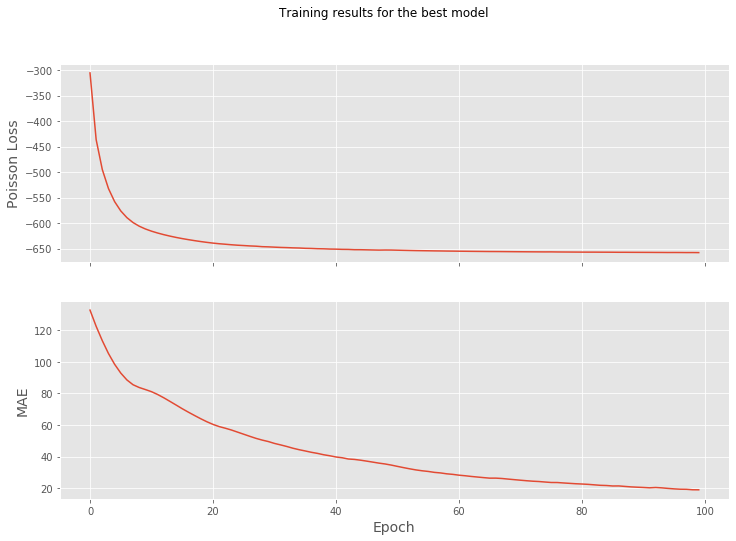

In [120]:
print("model function", best_model)
print("model:", best_estimator.model.summary())

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training results for the best model')

axes[0].set_ylabel("Poisson Loss", fontsize=14)
axes[0].plot(best_history.history['loss'])

axes[1].set_ylabel("MAE", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(best_history.history['mae'])
plt.show()

Mean Abosulte Error score of the best model on the test dataset is  : 145.72438


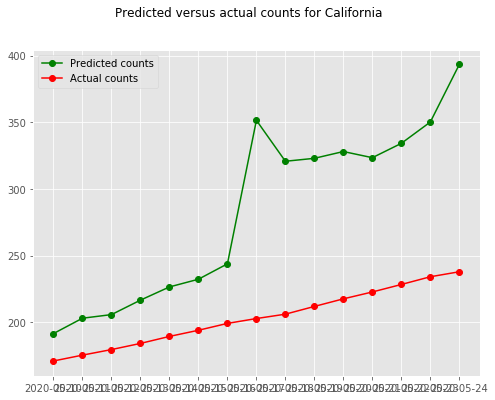

<Figure size 576x432 with 0 Axes>

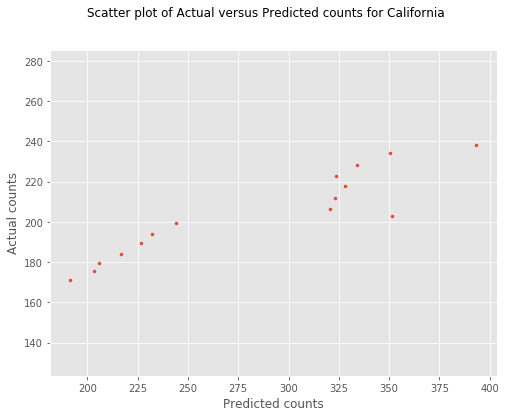

In [103]:
# on the total test dataset we find the MAE
kr = KerasRegressor(build_fn= best_model, epochs=100, batch_size= 16, verbose=0)
kr.fit(X, y)
y_pred = kr.predict(Xt)
print("Mean Abosulte Error score of the best model on the test dataset is  : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
fig = plt.figure()
fig.suptitle('Predicted versus actual counts for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts for California')
plt.scatter(x=y_pred[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

In [ ]:
# (Experimental )
# shape the training data and test data to create another  dataset but with percentage outside = 100 - percentage home column 
XPrime_tr = X_tr.loc[:, ['Province_State',	'Population',	'Elapsed_Days']]
XPrime_tr['percentage_Outside'] = 100 - X_tr.loc[:, 'Percentage_Home']
# standardizing the training data
categoriesPrime, scalerPrime, encoderPrime = standardize_fit2(XPrime_tr)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
XPrime_tr_std = standardize_transfrom2(XPrime_tr, scalerPrime, encoderPrime)

XPrime_te = X_te.loc[:, ['Province_State',	'Population',	'Elapsed_Days']]
XPrime_te['percentage_Outside'] = 100 - X_te.loc[:, 'Percentage_Home']
#standardizing the test data from the previously fitted standardizers
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
XPrime_te_std = standardize_transfrom2(XPrime_te, scalerPrime, encoderPrime)



# remove

In [43]:
#importing the train set
X_tr = pd.read_csv('../data/X_weekly_tr.csv')   
y_tr = pd.read_csv('../data/y_weekly_tr.csv') 
print(X_tr.shape)
print(y_tr.shape)

(436, 6)
(436, 2)


In [44]:
# just to make sure if any Null is left
print ("number of nulls left is ", len(X_tr[X_tr.isnull().values == True].head()))

number of nulls left is  0


In [45]:
X_tr.head()

,Date,Province_State,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
0,2020-02-02,Arizona,27.624795,0,0.013739,0.0
1,2020-02-02,Illinois,25.986911,0,0.015783,1.0
2,2020-02-02,California,25.540295,0,0.007593,0.5
3,2020-02-02,Washington,27.401260,0,0.013132,0.0
4,2020-02-09,California,23.975602,0,0.015185,1.0


In [46]:
X_tr.describe()

,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
count,436.000000,436.000000,436.000000,436.000000
mean,36.968382,29.350917,115.964551,inf
std,6.596189,17.847071,212.076329,NaN
min,21.758841,0.000000,0.003449,0.000000
25%,32.912088,14.000000,6.271094,0.337615
50%,37.020951,29.000000,45.478209,0.857958
75%,41.261225,45.000000,121.404014,3.273119
max,61.343387,67.000000,1626.514549,inf


In [47]:
# (Explore can we cross validate with splitting by each day?)
train_timestamps = X_tr['Date'].values
train_timestamps[:5]

array(['2020-02-02', '2020-02-02', '2020-02-02', '2020-02-02',
       '2020-02-09'], dtype=object)

In [49]:
y_tr.head()

,Date,Incident_Rate
0,2020-02-02,0.013739
1,2020-02-02,0.015783
2,2020-02-02,0.015185
3,2020-02-02,0.013132
4,2020-02-09,0.020247


In [50]:
y_tr.describe()

,Incident_Rate
count,436.000000
mean,157.881929
std,253.203852
min,0.003449
25%,23.487310
50%,70.695913
75%,168.224115
max,1724.080234


In [51]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
print(X_tr.shape)
print(y_tr.shape)

(436, 5)
(436, 1)
